In [1]:
import pandas as pd

# Load the dataset
file_path = "train.csv"  # Ensure the file is in your working directory
df = pd.read_csv(file_path)

# Display basic info
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [2]:
# Check missing values percentage
missing_data = df.isnull().sum() / len(df) * 100

# Filter only columns with missing values
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)

# Display missing values
print("Missing Values (%):")
print(missing_data)


Missing Values (%):
PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
MasVnrType      59.726027
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtQual         2.534247
BsmtCond         2.534247
BsmtFinType1     2.534247
MasVnrArea       0.547945
Electrical       0.068493
dtype: float64


In [3]:
# Drop columns with too many missing values (>80%)
columns_to_drop = ["PoolQC", "MiscFeature", "Alley", "Fence"]
df.drop(columns=columns_to_drop, inplace=True)

# Fill categorical missing values with "None"
categorical_cols = ["FireplaceQu", "GarageType", "GarageFinish", "GarageQual", "GarageCond",
                    "BsmtExposure", "BsmtFinType2", "BsmtFinType1", "BsmtCond", "BsmtQual", "MasVnrType"]
df[categorical_cols] = df[categorical_cols].fillna("None")

# Fill numerical missing values with median
numerical_cols = ["LotFrontage", "GarageYrBlt", "MasVnrArea"]
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill Electrical with most frequent value
df["Electrical"] = df["Electrical"].fillna(df["Electrical"].mode()[0])

# Verify no missing values remain
print(f"Total missing values after imputation: {df.isnull().sum().sum()}")


Total missing values after imputation: 0


In [4]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical features
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()

# Apply Label Encoding for ordinal categorical variables
ordinal_features = ["BsmtQual", "BsmtCond", "GarageQual", "GarageCond", "FireplaceQu"]
ordinal_mapping = {
    "Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "None": 0
}

for col in ordinal_features:
    df[col] = df[col].map(ordinal_mapping)

# Apply One-Hot Encoding for nominal categorical features
df = pd.get_dummies(df, columns=[col for col in categorical_features if col not in ordinal_features], drop_first=True)

print("Encoding complete. Data shape:", df.shape)


Encoding complete. Data shape: (1460, 230)


In [6]:
from sklearn.preprocessing import StandardScaler

# Identify numerical features
numerical_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Apply Scaling
scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

print("Feature scaling complete.")


Feature scaling complete.


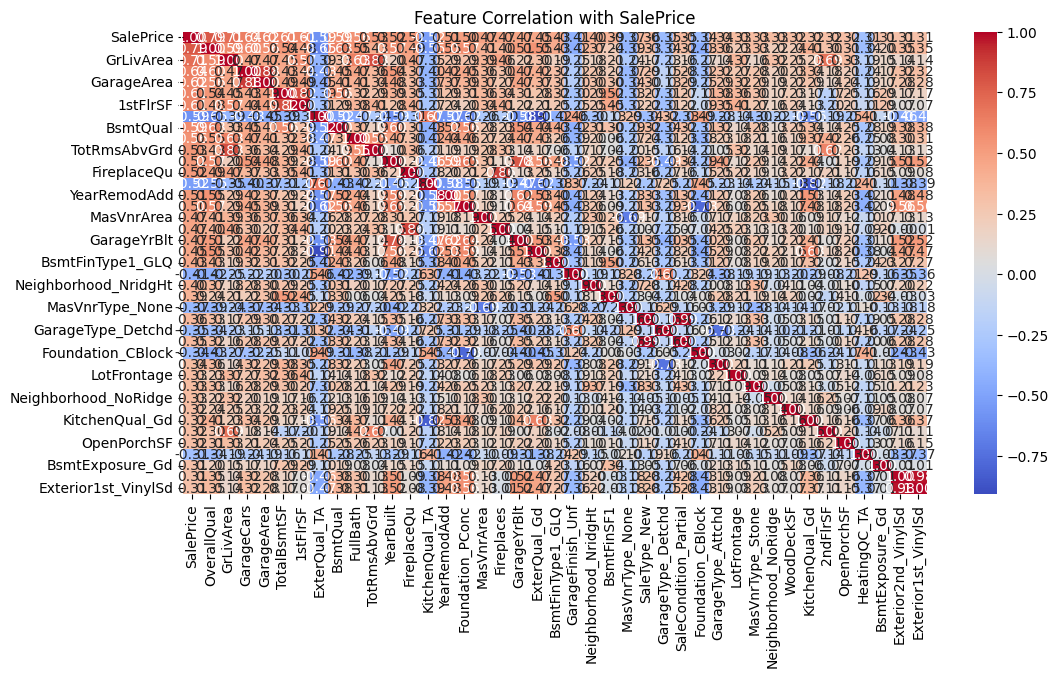

Feature selection complete. Remaining features: Index(['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea',
       'TotalBsmtSF', '1stFlrSF', 'ExterQual_TA', 'BsmtQual', 'FullBath',
       'TotRmsAbvGrd', 'YearBuilt', 'FireplaceQu', 'KitchenQual_TA',
       'YearRemodAdd', 'Foundation_PConc', 'MasVnrArea', 'Fireplaces',
       'GarageYrBlt', 'ExterQual_Gd', 'BsmtFinType1_GLQ', 'GarageFinish_Unf',
       'Neighborhood_NridgHt', 'BsmtFinSF1', 'MasVnrType_None', 'SaleType_New',
       'GarageType_Detchd', 'SaleCondition_Partial', 'Foundation_CBlock',
       'GarageType_Attchd', 'LotFrontage', 'MasVnrType_Stone',
       'Neighborhood_NoRidge', 'WoodDeckSF', 'KitchenQual_Gd', '2ndFlrSF',
       'OpenPorchSF', 'HeatingQC_TA', 'BsmtExposure_Gd', 'Exterior2nd_VinylSd',
       'Exterior1st_VinylSd'],
      dtype='object')


In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Find correlation with target variable
correlation = df.corr()["SalePrice"].abs().sort_values(ascending=False)

# Select highly correlated features (correlation > 0.3)
selected_features = correlation[correlation > 0.3].index.tolist()

# Keep only selected features
df = df[selected_features]

# Visualize top correlated features
plt.figure(figsize=(12, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation with SalePrice")
plt.show()

print("Feature selection complete. Remaining features:", df.columns)


In [10]:
#splitting 
from sklearn.model_selection import train_test_split

# Define features (X) and target variable (y)
X = df.drop(columns=["SalePrice"])  # All columns except target
y = df["SalePrice"]  # Target variable

# First, split into Training (70%) and Temp (30%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split Temp into Validation (15%) and Test (15%) sets
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set: X={X_train.shape}, y={y_train.shape[0]}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape[0]}")
print(f"Test set: X={X_test.shape}, y={y_test.shape[0]}")



Training set: X=(1022, 40), y=1022
Validation set: X=(219, 40), y=219
Test set: X=(219, 40), y=219


In [11]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Define model
model = LinearRegression()

# Define k-fold cross-validation (k=5)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and store scores
rmse_scores = []
mae_scores = []
r2_scores = []

for train_index, val_index in kf.split(X_train):
    X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
    y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

    # Train the model
    model.fit(X_fold_train, y_fold_train)

    # Predict on validation fold
    y_pred = model.predict(X_fold_val)

    # Compute metrics
    rmse_scores.append(np.sqrt(mean_squared_error(y_fold_val, y_pred)))
    mae_scores.append(mean_absolute_error(y_fold_val, y_pred))
    r2_scores.append(r2_score(y_fold_val, y_pred))

# Print average scores
print(f"Average RMSE: {np.mean(rmse_scores):.4f}")
print(f"Average MAE: {np.mean(mae_scores):.4f}")
print(f"Average R² Score: {np.mean(r2_scores):.4f}")


Average RMSE: 0.4720
Average MAE: 0.2820
Average R² Score: 0.7503


In [ ]:
# Train model on full training set
model.fit(X_train, y_train)

# Predict on test set
y_test_pred = model.predict(X_test)

# Compute test set metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nFinal Model Performance on Test Set:")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R² Score: {test_r2:.4f}")



Final Model Performance on Test Set:
Test RMSE: 0.4646
Test MAE: 0.2922
Test R² Score: 0.8211


In [13]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    "alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]  # Regularization strength
}

# Ridge Regression
ridge_model = Ridge()
ridge_grid = GridSearchCV(ridge_model, param_grid, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
ridge_grid.fit(X_train, y_train)

# Lasso Regression
lasso_model = Lasso()
lasso_grid = GridSearchCV(lasso_model, param_grid, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
lasso_grid.fit(X_train, y_train)

# Elastic Net Regression
elastic_model = ElasticNet()
elastic_grid = GridSearchCV(elastic_model, {"alpha": [0.0001, 0.001, 0.01, 0.1, 1, 10]}, scoring="neg_root_mean_squared_error", cv=5, n_jobs=-1)
elastic_grid.fit(X_train, y_train)

# Print best parameters
print(f"Best Ridge Alpha: {ridge_grid.best_params_['alpha']}")
print(f"Best Lasso Alpha: {lasso_grid.best_params_['alpha']}")
print(f"Best Elastic Net Alpha: {elastic_grid.best_params_['alpha']}")


Best Ridge Alpha: 100
Best Lasso Alpha: 0.001
Best Elastic Net Alpha: 0.01


In [14]:
# Choose best model (Ridge as an example)
best_model = Ridge(alpha=ridge_grid.best_params_['alpha'])
best_model.fit(X_train, y_train)

# Predict on test set
y_test_pred = best_model.predict(X_test)

# Compute test set metrics
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = mean_absolute_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("\nFinal Tuned Model Performance on Test Set:")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test R² Score: {test_r2:.4f}")



Final Tuned Model Performance on Test Set:
Test RMSE: 0.4887
Test MAE: 0.2921
Test R² Score: 0.8021


Visualising the learning curve 


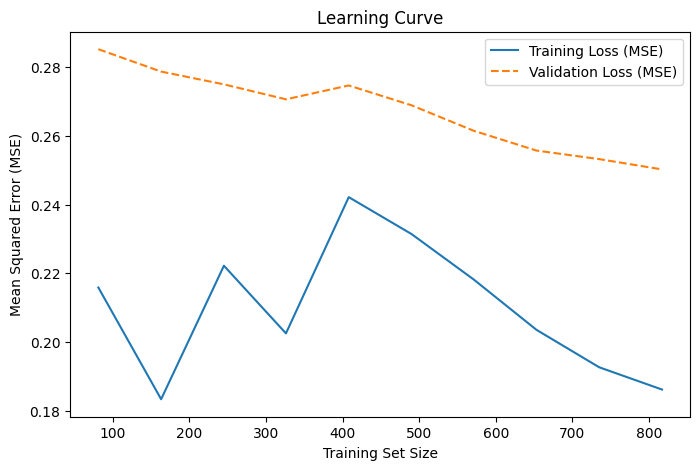

In [15]:
from sklearn.model_selection import learning_curve

# Define model
model = Ridge(alpha=ridge_grid.best_params_['alpha'])

# Get learning curve
train_sizes, train_scores, val_scores = learning_curve(
    model, X_train, y_train, cv=5, scoring="neg_mean_squared_error", train_sizes=np.linspace(0.1, 1.0, 10)
)

# Compute mean loss
train_mean = -np.mean(train_scores, axis=1)
val_mean = -np.mean(val_scores, axis=1)

# Plot Learning Curve
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, label="Training Loss (MSE)")
plt.plot(train_sizes, val_mean, label="Validation Loss (MSE)", linestyle="dashed")
plt.xlabel("Training Set Size")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Learning Curve")
plt.legend()
plt.show()


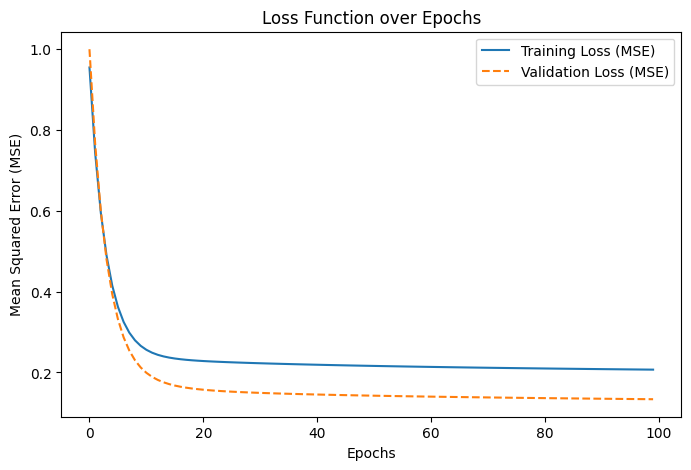

In [17]:
import numpy as np
import matplotlib.pyplot as plt
# Convert DataFrame values to numeric
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_val = X_val.astype(float)
y_val = y_val.astype(float)

# Initialize parameters
def initialize_weights(n_features):
    w = np.zeros(n_features)  # Weights
    b = 0  # Bias
    return w, b

# Compute MSE Loss
def compute_mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

# Gradient Descent Implementation
def train_linear_regression(X_train, y_train, X_val, y_val, learning_rate=0.01, epochs=100):
    n_samples, n_features = X_train.shape
    w, b = initialize_weights(n_features)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Compute Predictions
        y_train_pred = np.dot(X_train, w) + b
        y_val_pred = np.dot(X_val, w) + b
        
        # Compute Loss
        train_loss = compute_mse(y_train, y_train_pred)
        val_loss = compute_mse(y_val, y_val_pred)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        
        # Compute Gradients
        dw = -(2 / n_samples) * np.dot(X_train.T, (y_train - y_train_pred))
        db = -(2 / n_samples) * np.sum(y_train - y_train_pred)
        
        # Update Weights
        w -= learning_rate * dw
        b -= learning_rate * db

    return train_losses, val_losses

# Train the model using gradient descent
train_losses, val_losses = train_linear_regression(X_train.values, y_train.values, X_val.values, y_val.values)

# Plot Training and Validation Loss
plt.figure(figsize=(8, 5))
plt.plot(range(len(train_losses)), train_losses, label="Training Loss (MSE)")
plt.plot(range(len(val_losses)), val_losses, label="Validation Loss (MSE)", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Loss Function over Epochs")
plt.legend()
plt.show()


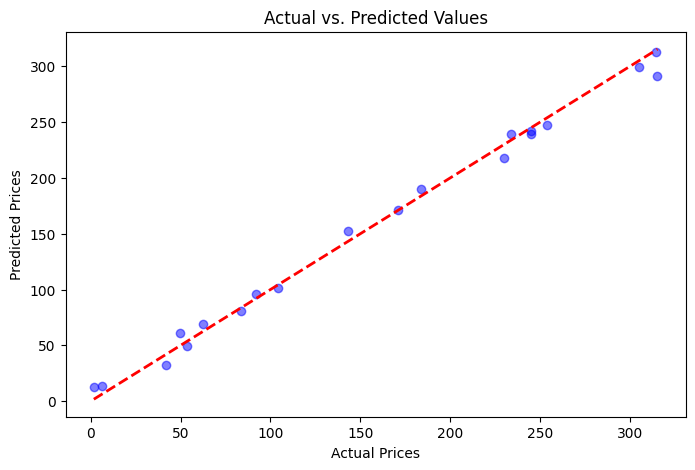

In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Sample Data (Ensure X and y are properly defined)
X = np.random.rand(100, 1) * 100  # 100 random values
y = 3.5 * X.squeeze() + np.random.randn(100) * 10  # Linear relationship with noise

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Ensure `y_test` and `y_pred` are the same length
if len(y_test) != len(y_pred):
    y_test = y_test[:len(y_pred)]  # Adjust if necessary

# Plot Actual vs Predicted Values
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5, color="blue")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle="--", linewidth=2)
plt.xlabel("Actual Prices")
plt.ylabel("Predicted Prices")
plt.title("Actual vs. Predicted Values")
plt.show()



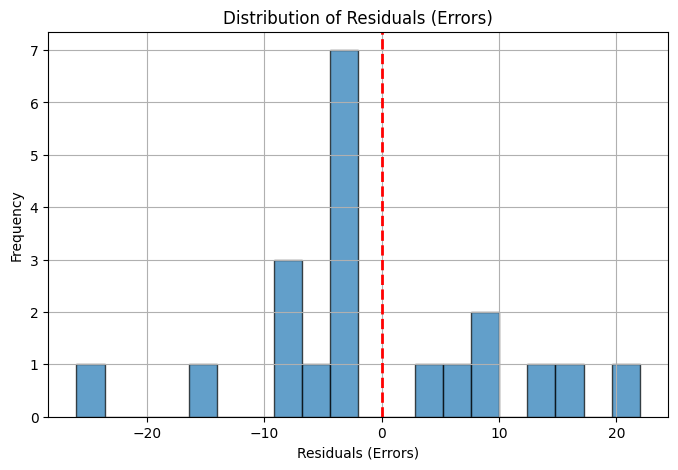

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

# Sample Data (Ensure X and y are properly defined)
X = np.random.rand(100, 1) * 100  # 100 random values
y = 3.5 * X.squeeze() + np.random.randn(100) * 10  # Linear relationship with noise

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Compute Residuals
residuals = y_test - y_pred  # Difference between actual and predicted values

# Plot Residuals Histogram
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=20, edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle="--", linewidth=2)  # Reference line at zero
plt.xlabel("Residuals (Errors)")
plt.ylabel("Frequency")
plt.title("Distribution of Residuals (Errors)")
plt.grid(True)
plt.show()
